In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import os
from PIL import Image 
import PIL 
from IPython.display import clear_output
  
from tensorflow import keras
from tensorflow.keras.models import Sequential

In [3]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.losses import binary_crossentropy

In [62]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask = tf.where(tf.equal(input_mask, 100), tf.ones_like(input_mask), input_mask)
    
    input_mask = tf.where(tf.equal(input_mask, 255), tf.ones_like(input_mask)*2, input_mask)
    #np.place(input_mask, input_mask==100, 1)
    #np.place(input_mask, input_mask==255, 2)
    return input_image, input_mask

In [4]:
df_pred = pd.read_csv('cc_pred.csv')
df_pred.head()

,base,pred,p_pred,diff,timestamp
0,13,0.537301,53.730100,40.730100,0101_0101075000
1,25,0.635413,63.541281,38.541281,0101_0101080000
2,37,0.573862,57.386153,20.386153,0101_0101081000
3,15,0.225565,22.556461,7.556461,0101_0101082000
4,18,0.244261,24.426138,6.426138,0101_0101083000


In [5]:
l = list(df_pred[df_pred['diff']<=20].index)


In [25]:
len(l)

15690

In [6]:
sets_count = 0
train_sets = []
for i in range(1,max(l)+1):
    if(set(list(range(i,i+8))).issubset(l)):
        #print(list(range(i,i+8)))
        train_sets.append(list(range(i,i+8)))
        sets_count +=1
sets_count

9941

In [29]:
to_consider = list(np.unique(train_sets))
filenames = []
for index in to_consider:
    filenames.append(df_pred['timestamp'][index])
    

In [34]:
folder,file = filenames[0].split('_')
im = plt.imread("dataset/train/"+folder+'/'+file+'.jpg')
im.shape

(1536, 1536, 3)

In [35]:
def create_circular_mask(h, w, center=None, radius=None):
    center = (int(w/2), int(h/2))
    #if radius is None: # use the smallest distance between the center and image walls
    radius = int(165 * w/180 * 0.5)#min(center[0], center[1], w-center[0], h-center[1])
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask
h,w,_ = im.shape
mask = create_circular_mask(h,w)

IMG_SIZE = 128

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

In [46]:
mask_ = np.expand_dims(np.array(mask,float),-1)
mask_s = tf.image.resize(mask_, (128, 128),method='nearest')
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def predict_cc(x):
    x_ = np.expand_dims(x,0)
    p = new_model.predict(x_)
    p = create_mask(p)
    (unique, counts) = np.unique(p, return_counts=True)
    frequencies = np.asarray((unique, counts)).T
    cc = frequencies[-1,1] / np.sum(mask_s)
    return cc,p

In [6]:
new_model = tf.keras.models.load_model('saved_model/cloud_seg')

In [ ]:
# decide valid images (not -1, not large negative)
# Apply segmentation to each image and save


In [83]:
for fn in filenames:
    folder,file = fn.split('_')
    im = plt.imread("dataset/train/"+folder+'/'+file+'.jpg')
    im2 = im.copy()
    #print(im2.shape)
    
    im2[~mask] = 0
    im2 = resize_and_rescale(im2)
    #print(im2.shape)
    #im2 = np.expand_dims(im2,0)
    _,p = predict_cc(im2)
    p_ = tf.where(tf.equal(p, 1), tf.ones_like(p)*0, p)
    p_ = tf.where(tf.equal(p_, 2), tf.ones_like(p_), p_)
    #print(p.shape)
    #plt.imshow(p_[:,:,0])
    
    im = Image.fromarray((np.array(p_[:,:,0]) * 255).astype(np.uint8))
    im.save('dataset/forecast/'+fn+".png")
    #break

In [7]:
# CREATE X and Y
X = []
Y = []
for tset in train_sets:
    #print(tset)
    tempx = []
    tempy = []
    for i,sample in enumerate(tset):
        fn = df_pred['timestamp'][sample]
        im = plt.imread("dataset/forecast/"+fn+".png")
        im = np.array(im,int)
        im = np.expand_dims(im,-1)
        #print(i,sample,fn,im.shape)
        if(i<4):
            tempx.append(im)
        else:
            tempy.append(im)
        
        
    tempx = np.array(tempx)
    tempy = np.array(tempy)
    X.append(tempx)
    Y.append(tempy)
    
X = np.array(X)
Y = np.array(Y)
        
print(X.shape, Y.shape)

(9941, 4, 128, 128, 1) (9941, 4, 128, 128, 1)


In [28]:
dataset_ = tf.data.Dataset.from_tensor_slices((X, Y))

In [29]:
DATASET_SIZE = X.shape[0]
train_size = int(0.1 * DATASET_SIZE)
val_size = int(0.01 * DATASET_SIZE)



full_dataset = dataset_.shuffle(DATASET_SIZE )
train_dataset = full_dataset.take(train_size)
temp_dataset = full_dataset.skip(train_size)
val_dataset = temp_dataset.take(val_size)
#val_dataset = temp_dataset.take(val_size)

batch_size=5   #TRY 128

train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *X.shape[2:]))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
)

In [30]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 1#2


# Fit the model to the training data.
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data= val_dataset,
    callbacks=[early_stopping, reduce_lr],
)

199/199 [==============================] - 3739s 19s/step - loss: 0.3563 - val_loss: 0.5657


In [53]:
history.history #5

{'loss': [0.311581552028656], 'val_loss': [0.300332635641098], 'lr': [0.001]}

In [50]:
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data= val_dataset,
    callbacks=[early_stopping, reduce_lr],
)

199/199 [==============================] - 4118s 21s/step - loss: 0.3116 - val_loss: 0.3003


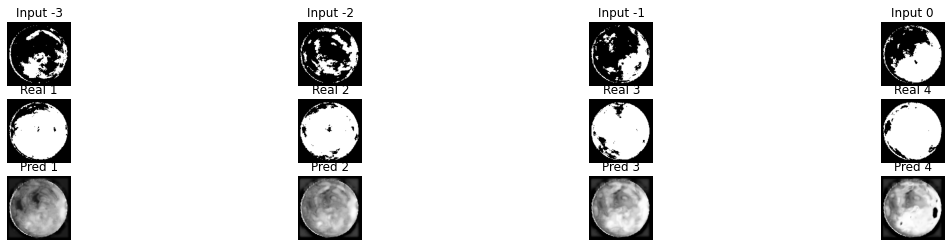

In [51]:
# Select a random example from the validation dataset.
for images, forcasts in val_dataset.take(1):
#    print(images.shape, forcasts.shape)
#    print(images[0].shape, forcasts[0].shape)
    break

# Pick the first/last ten frames from the example.
frames = images[0]#example[:4, ...]
original_frames = images[0]#example[4:, ...]

# Predict a new set of 10 frames.
for _ in range(4):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(3, 4, figsize=(20, 4))



# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Input {idx + -3}")
    ax.axis("off")
    

for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(forcasts[0][idx]), cmap="gray")
    ax.set_title(f"Real {idx + 1}")
    ax.axis("off")

# Plot the new frames.
new_frames = frames[4:, ...]
for idx, ax in enumerate(axes[2]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
    ax.set_title(f"Pred {idx + 1}")
    ax.axis("off")

# Display the figure.
plt.show()

In [52]:
!mkdir -p saved_model_pred
model.save('saved_model_pred/cloud_pred')

A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file saved_model_pred already exists.
Error occurred while processing: saved_model_pred.


INFO:tensorflow:Assets written to: saved_model_pred/cloud_pred\assets


#### Reference
1. https://keras.io/examples/vision/conv_lstm/